# Drought hazard team rainfall percentile output processing

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi')
import utils

#### BC SWITCH (toggle on / off)

In [2]:
BC_SWITCH = True

## GWL slicing

In [5]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


### 10-50-90 Percentiles for GWL and change between GWLs

In [4]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*p15*{}".format(input_dir, '.nc'))))

In [5]:
files

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.5_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL3.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1

In [26]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}p15_3month_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


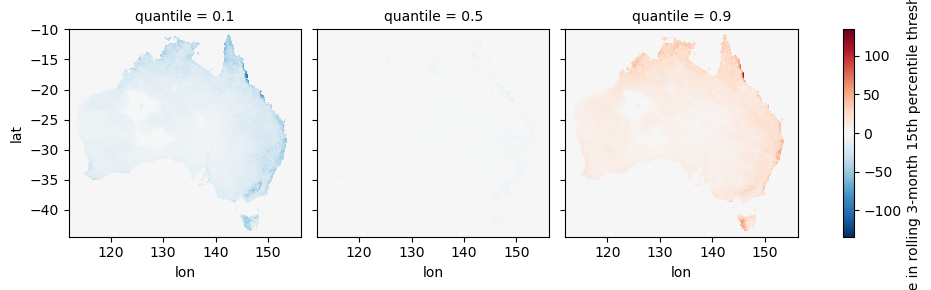

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

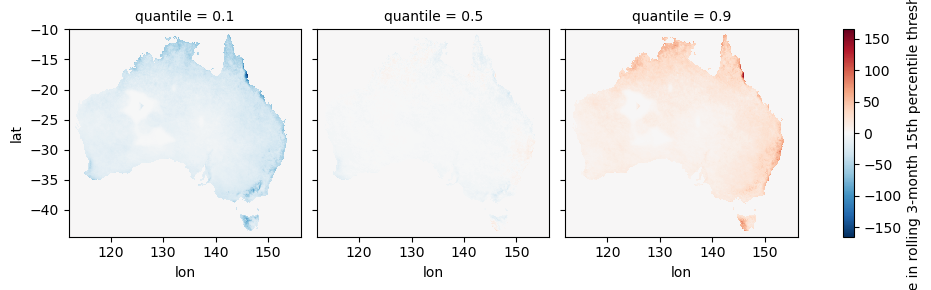

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

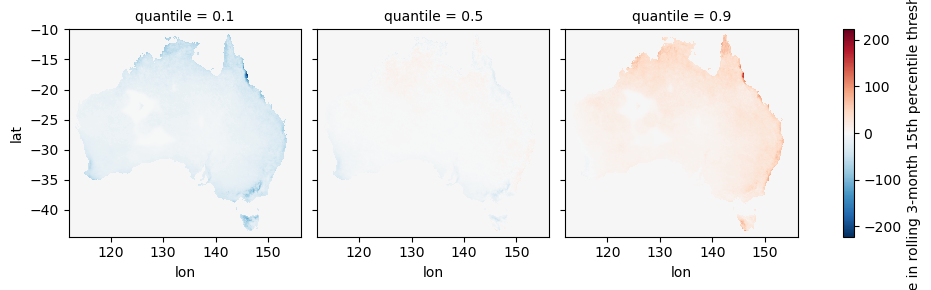

<Figure size 640x480 with 0 Axes>

In [27]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc")
    (quick_check_ds.p15_3month.mean(dim='month')).plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in rolling 3-month 15th percentile threshold (mm)'})
    plt.show()
    plt.clf()

### Plotting

In [3]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [4]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

In [5]:
# %%time
# plot_acs_hazard(data = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc').sel(month='DJF').p15_3month,
#                     regions = regions_dict['ncra_regions'],
#                     cmap = cmap_dict["pr"],
#                     ticks = tick_dict["pr_mon"],
#                     cbar_label = "15th Percentile threshold (mm)",
#                     cbar_extend = "max",
#                     title = "BARPA-R ACCESS-ESM1-5 NDJ 15th Percentile threshold (GWL=2.0)",
#                     dataset_name = "BARPA-R",
#                     date_range = "November-December-January",
#                    );

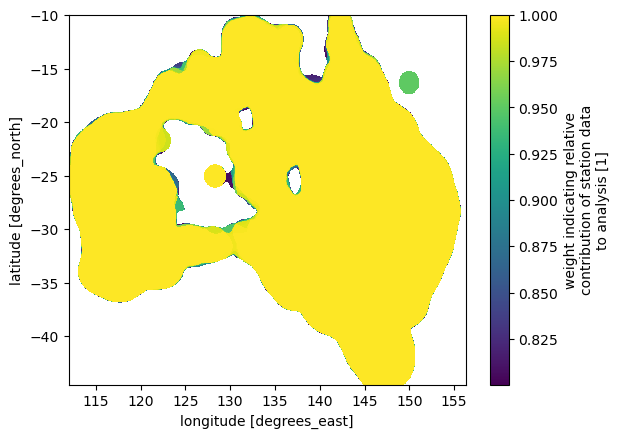

In [6]:
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc")
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)
mask_ds.fraction.where(q_mask.mask).plot()

CPU times: user 3min 1s, sys: 1.39 s, total: 3min 2s
Wall time: 3min 3s


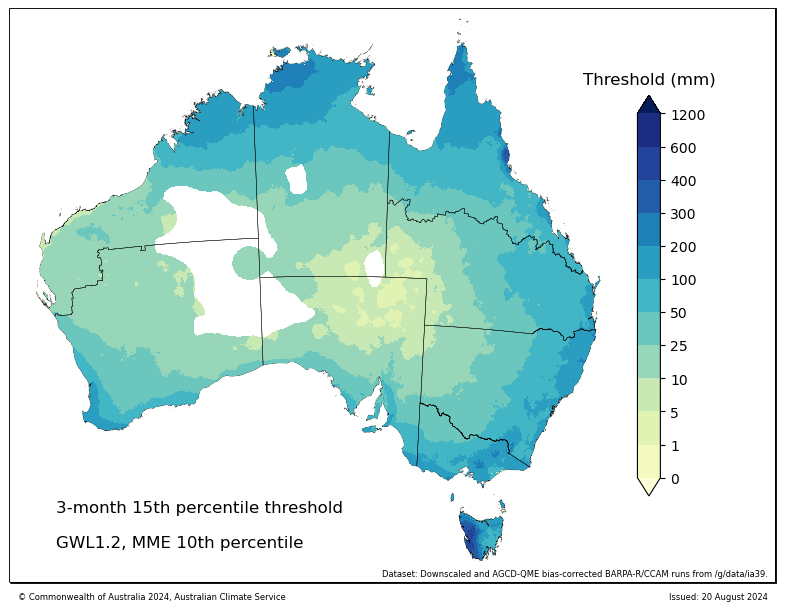

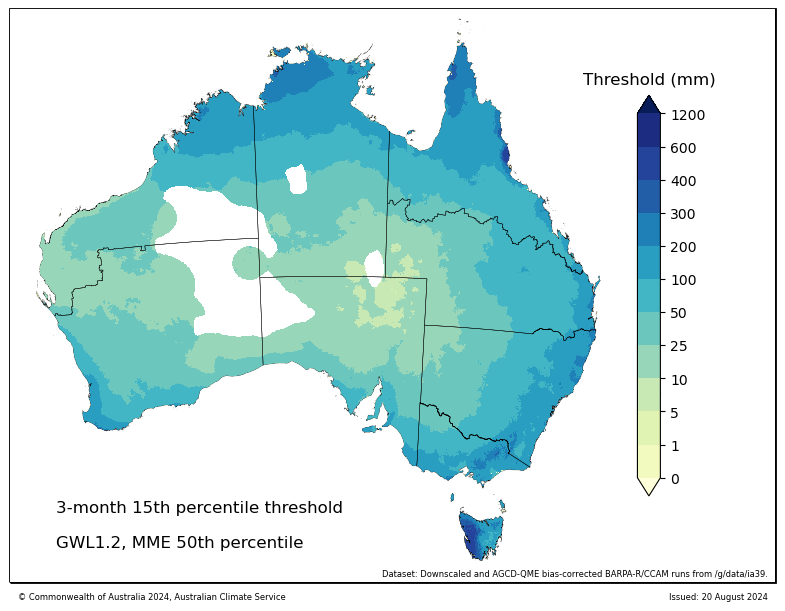

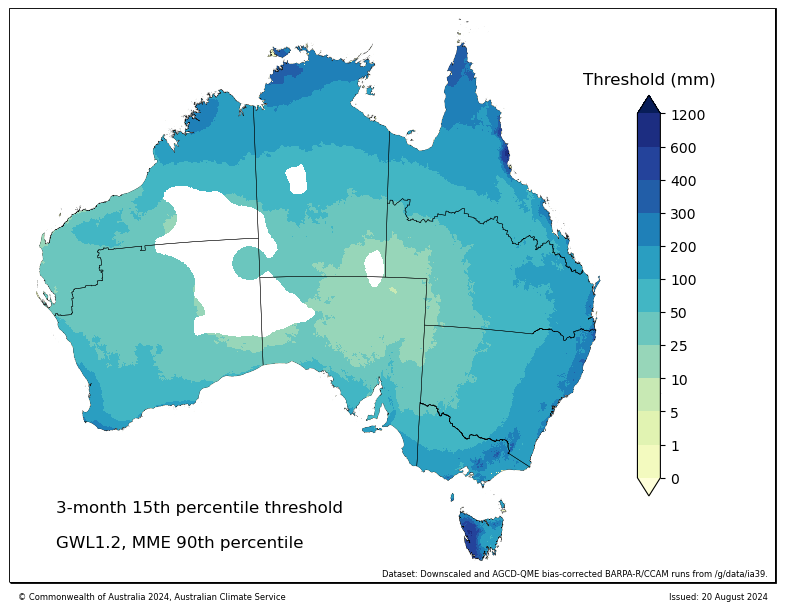

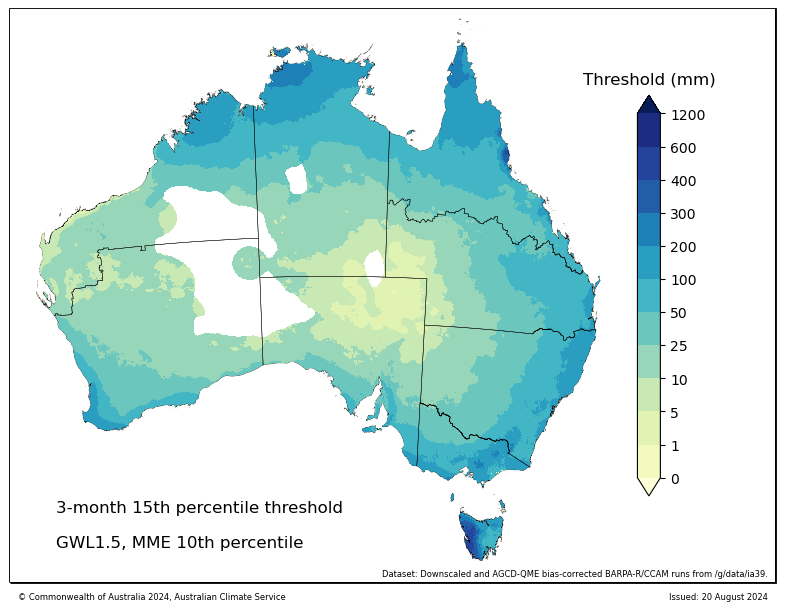

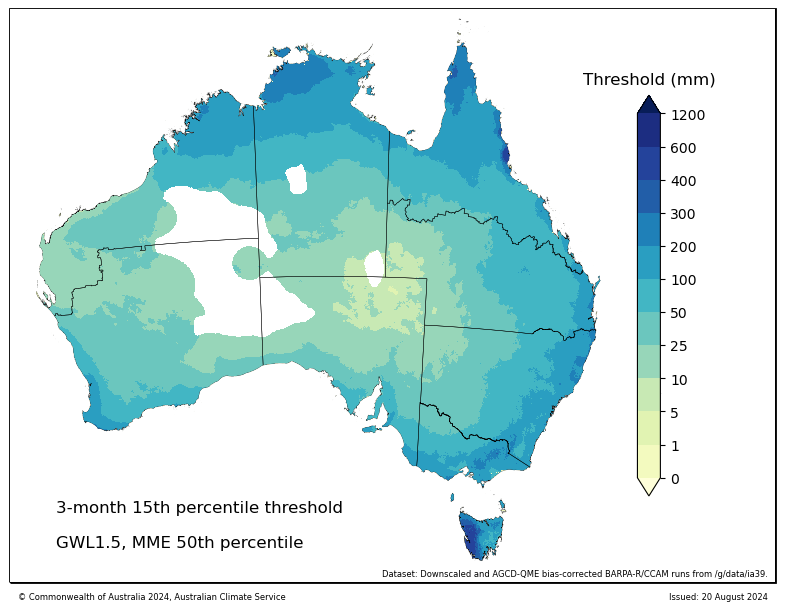

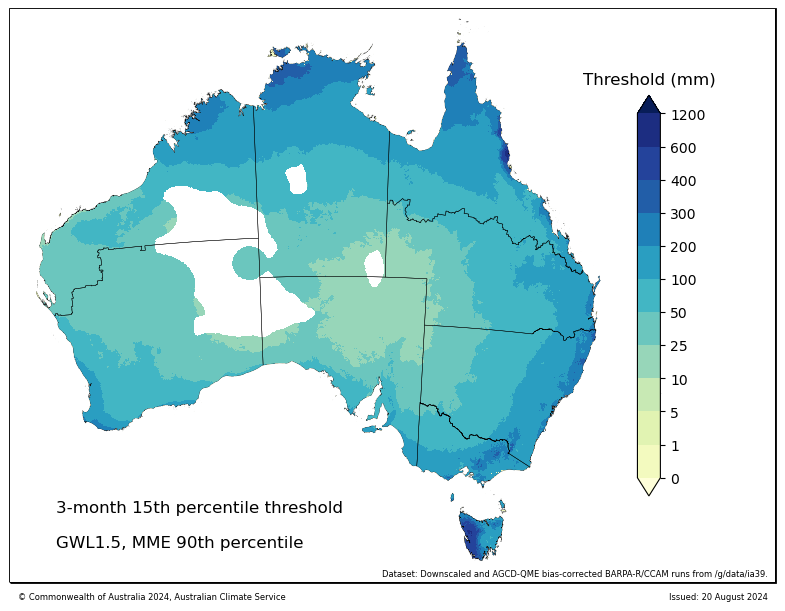

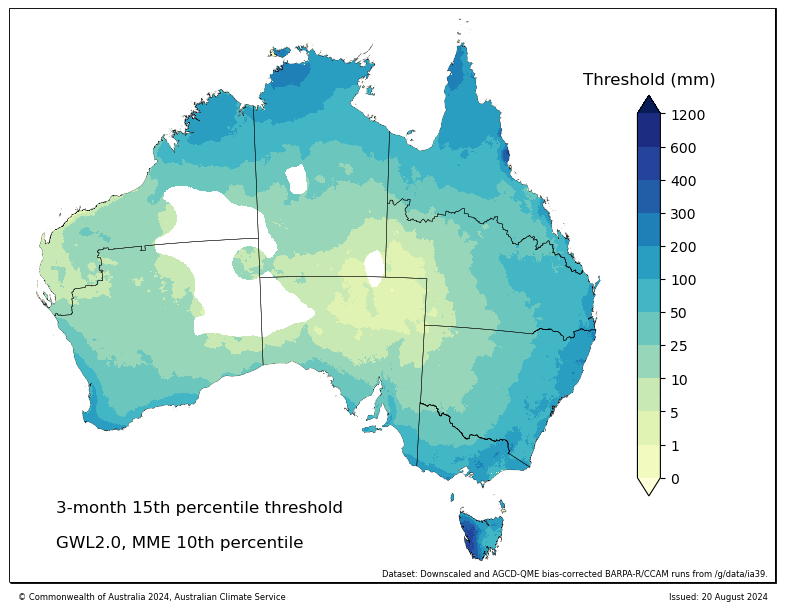

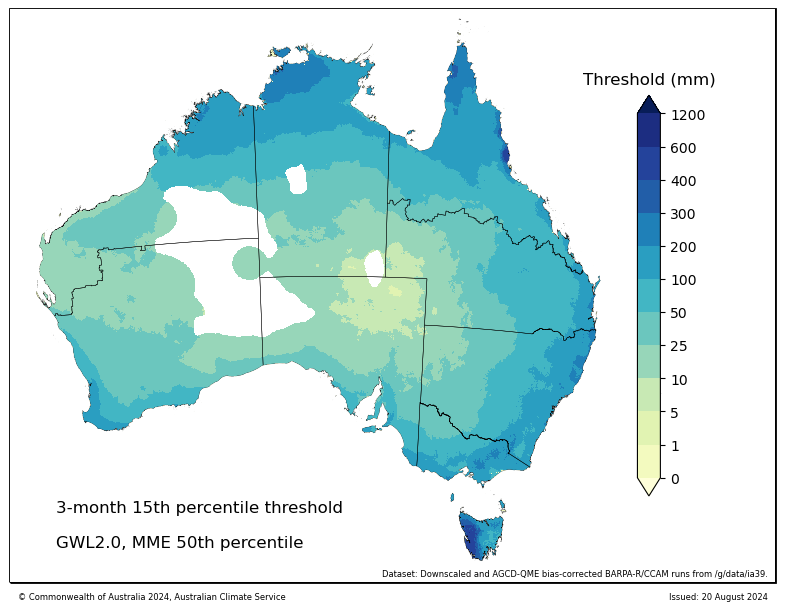

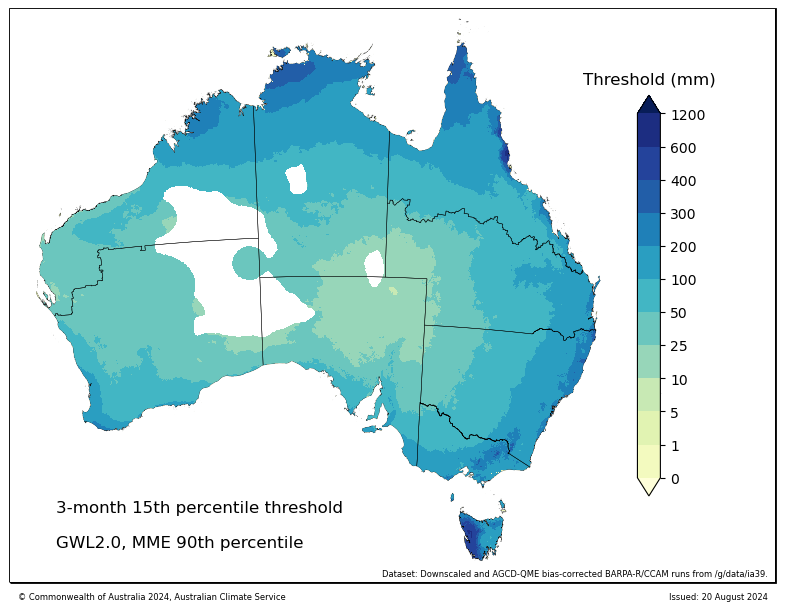

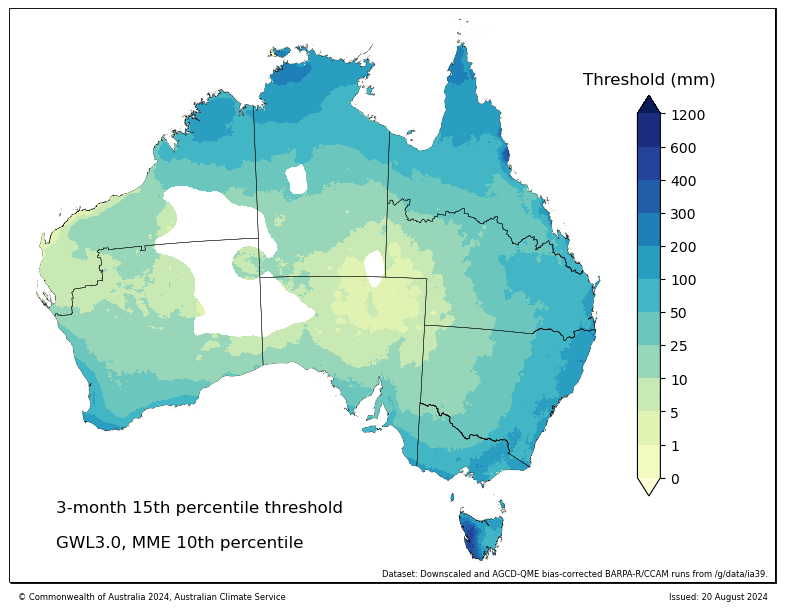

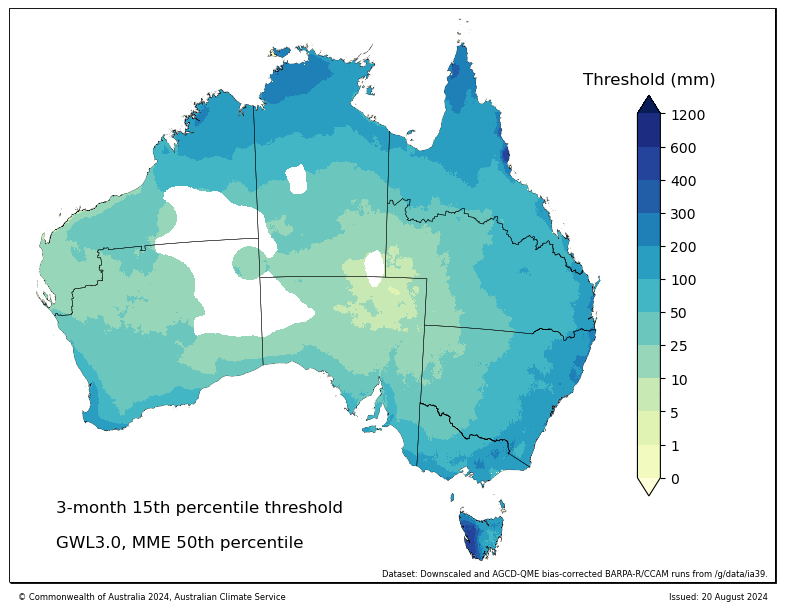

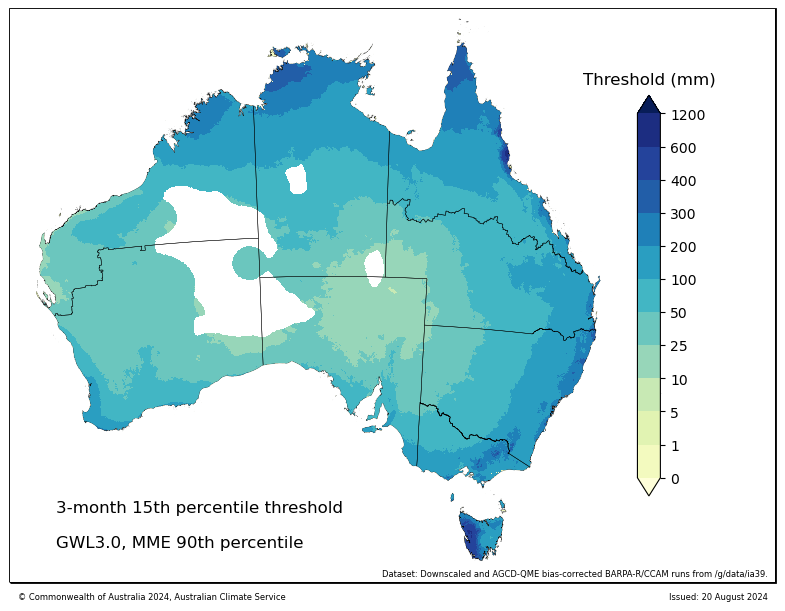

In [7]:
%%time
for GWL in [1.2, 1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        if BC_SWITCH:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        else:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/p15_3month_GWL_{str(GWL)}_percentiles_10-50-90.nc"
        plot_acs_hazard(data = (xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month')) if BC_SWITCH==False else (xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month')).where(q_mask.mask),
        regions = regions_dict['ncra_regions'],
        cmap = cmap_dict["pr"],
        ticks = tick_dict["pr_mon"],
        cbar_label = "Threshold (mm)",
        cbar_extend = "both",
        title = f"3-month 15th percentile threshold\n",
        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39." if BC_SWITCH == False else "Downscaled and AGCD-QME bias-corrected BARPA-R/CCAM runs from /g/data/ia39.",
        date_range = f"GWL{str(GWL)}, MME {str(int(percentile*100))}th percentile",
        watermark = None,
        contourf = False,
        contour = False,
        outfile = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/figures/p15_3month_GWL{str(GWL)}_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/figures/p15_3month_GWL{str(GWL)}_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}_masked.png"
        );

CPU times: user 1min, sys: 490 ms, total: 1min
Wall time: 1min


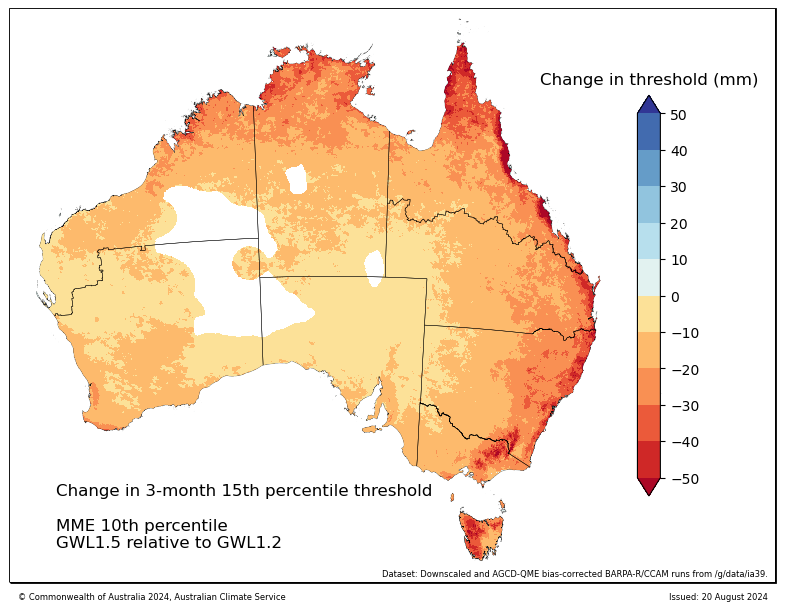

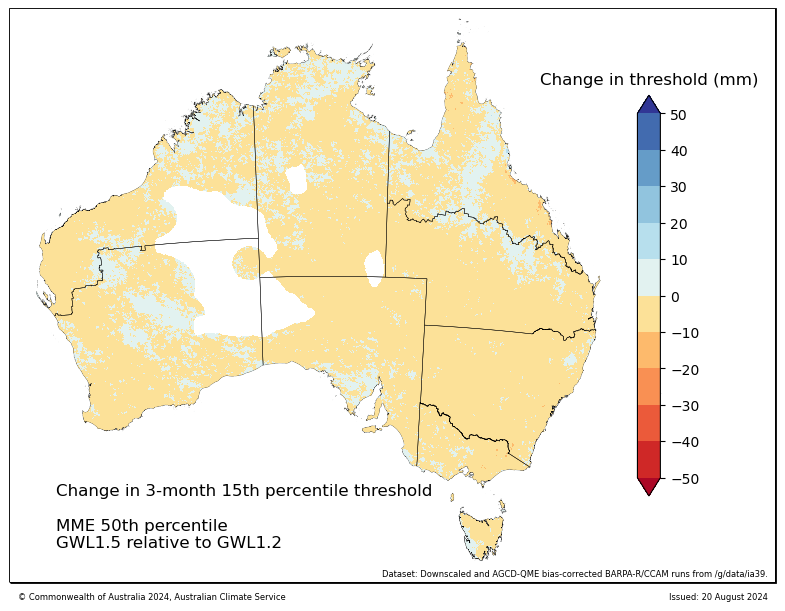

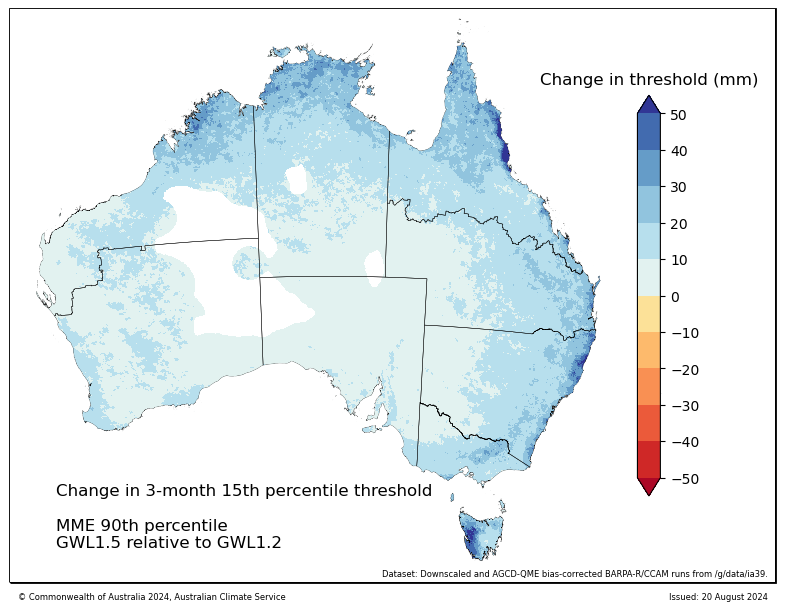

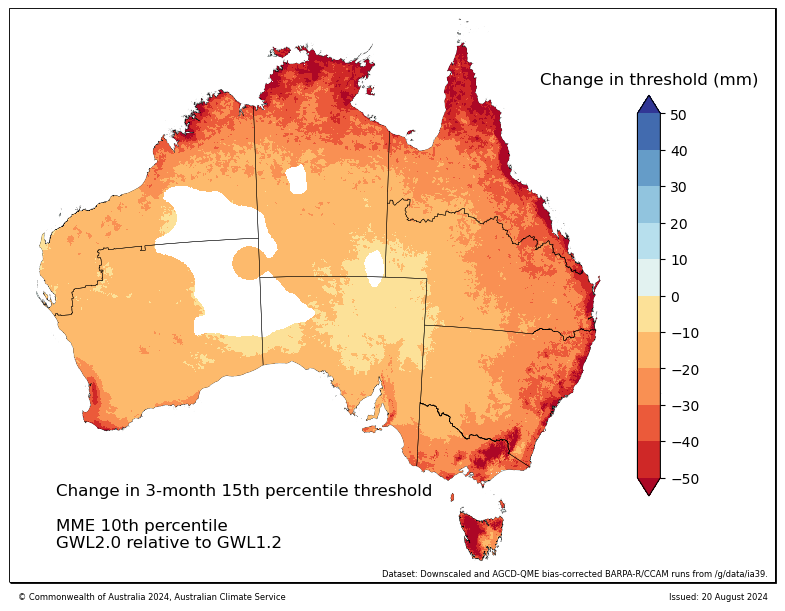

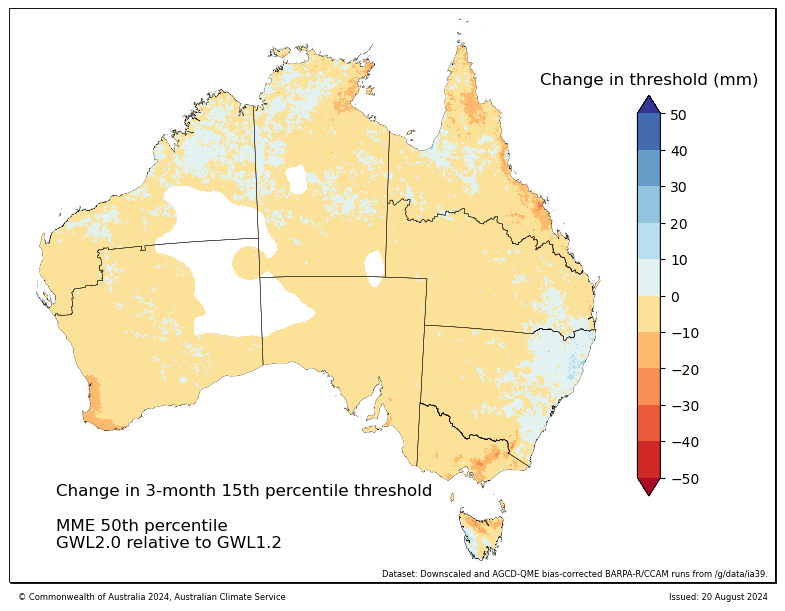

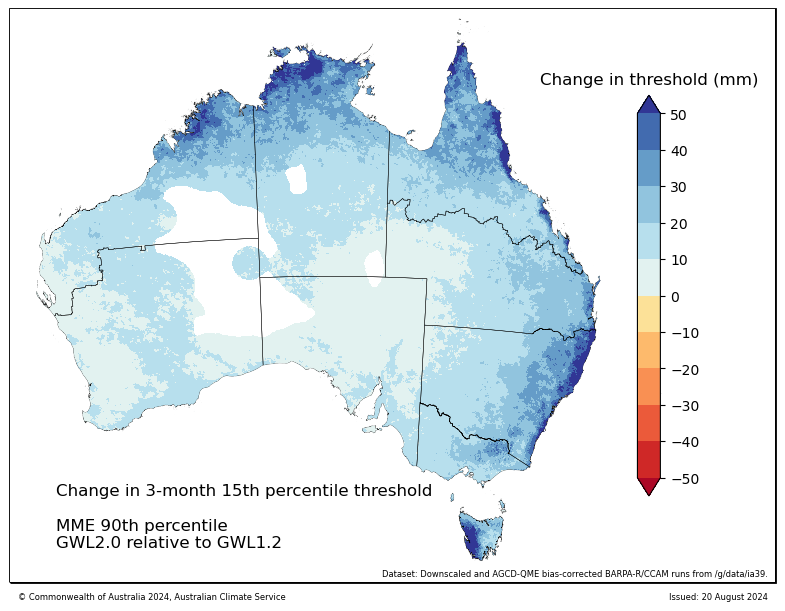

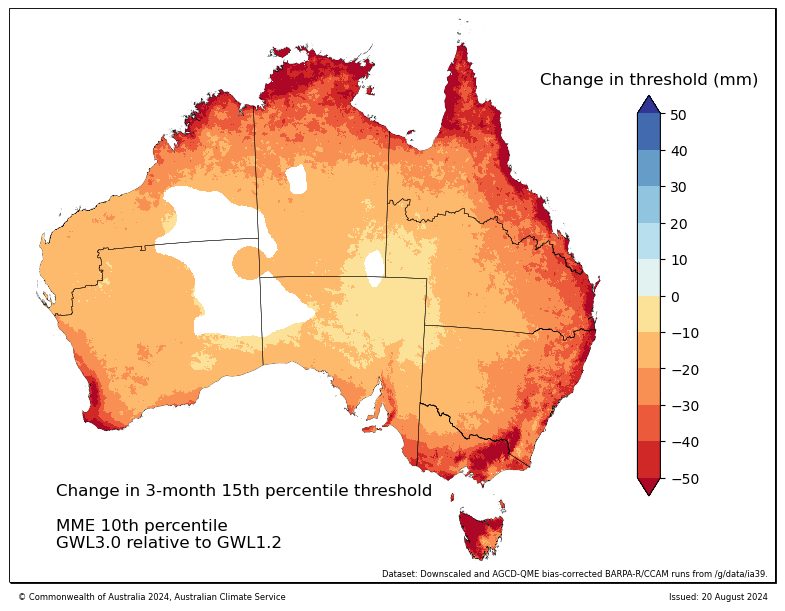

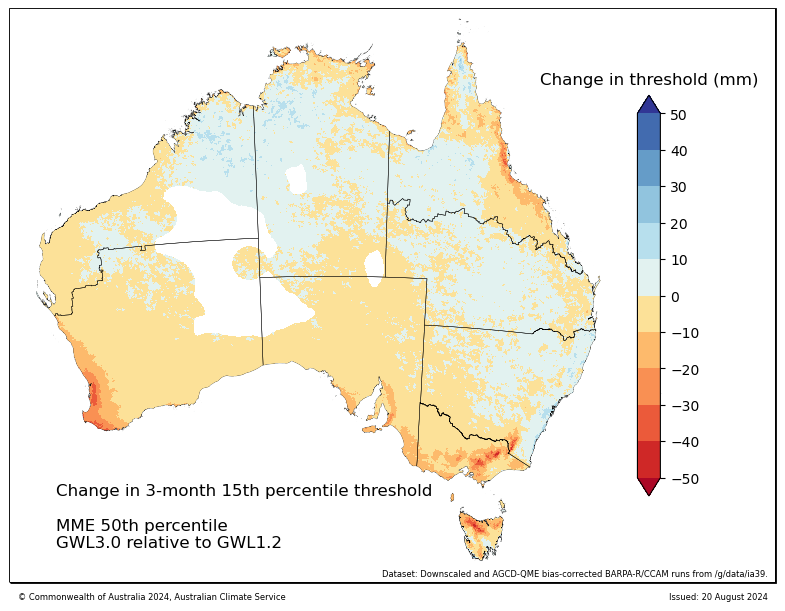

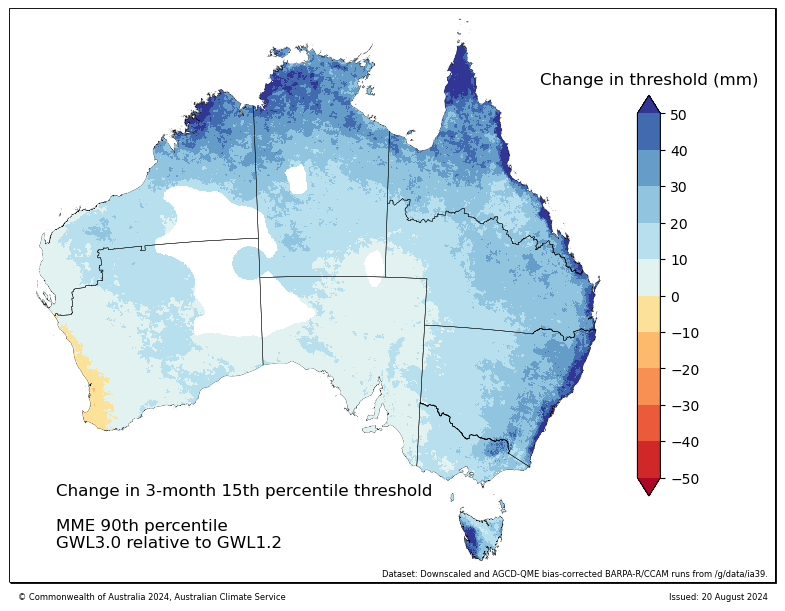

In [8]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        if BC_SWITCH:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        else:
            plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc"
        plot_acs_hazard(data = (xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month')) if BC_SWITCH == False else (xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month')).where(q_mask.mask),
        regions = regions_dict['ncra_regions'],
        cmap = cmap_dict["anom_b2r_r"],
        ticks = np.arange(-50, 50.1, 10),
        cbar_label = "Change in threshold (mm)",
        cbar_extend = "both",
        title = f"Change in 3-month 15th percentile threshold\n\nMME {str(int(percentile*100))}th percentile",
        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39." if BC_SWITCH == False else "Downscaled and AGCD-QME bias-corrected BARPA-R/CCAM runs from /g/data/ia39.",
        date_range = f"GWL{str(GWL)} relative to GWL1.2",
        watermark = None,
        contourf = False,
        contour = False,
        outfile = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/figures/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/figures/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}_masked.png"
        # outfile = f"/g/data/ia39/ncra/drought_aridity/rainfall_15prctl_figures_31July/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/rainfall_15prctl_figures_31July/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}.png"
        );



## Regional statistics and heatmaps
using IPCC-style method - 'Method 3 - IPCC style' (metric and regional mean for each model, then multi model median)

In [3]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [4]:
from acs_area_statistics import acs_regional_stats, regions

In [5]:
def plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    min_max_extent = {1.5:10, 2.0:15, 3.0:20}
    sns.set(font_scale=1.5)
    plt.figure(figsize=(18, 7))
    colors = sns.color_palette("PRGn", 10)
    cmap = ListedColormap(colors)
    
    ax = sns.heatmap(plot_df, annot=True, cmap=cmap, linewidth=2, fmt='.0f',
                     cbar_kws={'extend':'both', 'label':'Change (mm)'},
                     center=0,
                     vmin=-(min_max_extent[GWL_level]) if variable_colourbar_switch else -50,
                     vmax=(min_max_extent[GWL_level]) if variable_colourbar_switch else 50,
                     yticklabels=list(change_df['abbrevs']),
                     xticklabels=[key[:-5].replace('_', ' ').replace('BOM', 'BARPA').replace('CSIRO', 'CCAM') for key in plot_df.columns])
    
    ax.text(len(plot_df.columns) + 0.85, - 0.5, 'Median' , ha='center', va='center')
    ax.text(len(plot_df.columns) + 0.23, 12, r"$\bf{Bold}$" + ' = at least\n66% of ensemble\nmembers agree on \nsign of the change' , size=16, ha='left', va='center', bbox=dict(boxstyle="round,pad=0.7", edgecolor="black", facecolor="none", linewidth=0.25))
    for i, row in plot_df.iterrows():
        median = row.median()
        sign_agreement = ((row>0).sum()/len(row)) if median > 0 else ((row<0).sum()/len(row))
        fontweight = 'bold' if sign_agreement >= 0.66 else 'normal'
        ax.text(len(plot_df.columns) + 0.85, i + 0.5, f'{median:.0f}', ha='center', va='center', fontweight=fontweight)
        
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.83, 0.15, 0.03, 0.7])
    
    ax.set_title(f'Change 15th percentile rainfall for GWL {str(GWL_level)} relative to GWL 1.2', fontweight='bold', pad=20)
    
    plt.savefig(f'/g/data/mn51/users/jb6465/drought-github/figures/15p_threshold_regional_heatmap_change_GWL{GWL_level}.png', bbox_inches='tight')
    plt.show()
    plt.clf()
    return

In [6]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/GWLs/'

files = []
files.extend(sorted(glob.glob("{}/*AGCD-05i*{}".format(input_dir, '.nc'))))

In [7]:
files

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.5_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL3.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1

In [8]:
files_GWL12 = [file for file in files if 'GWL1.2' in file]

---> Plotting GWL1.5 with consistent colourbar across GWLs


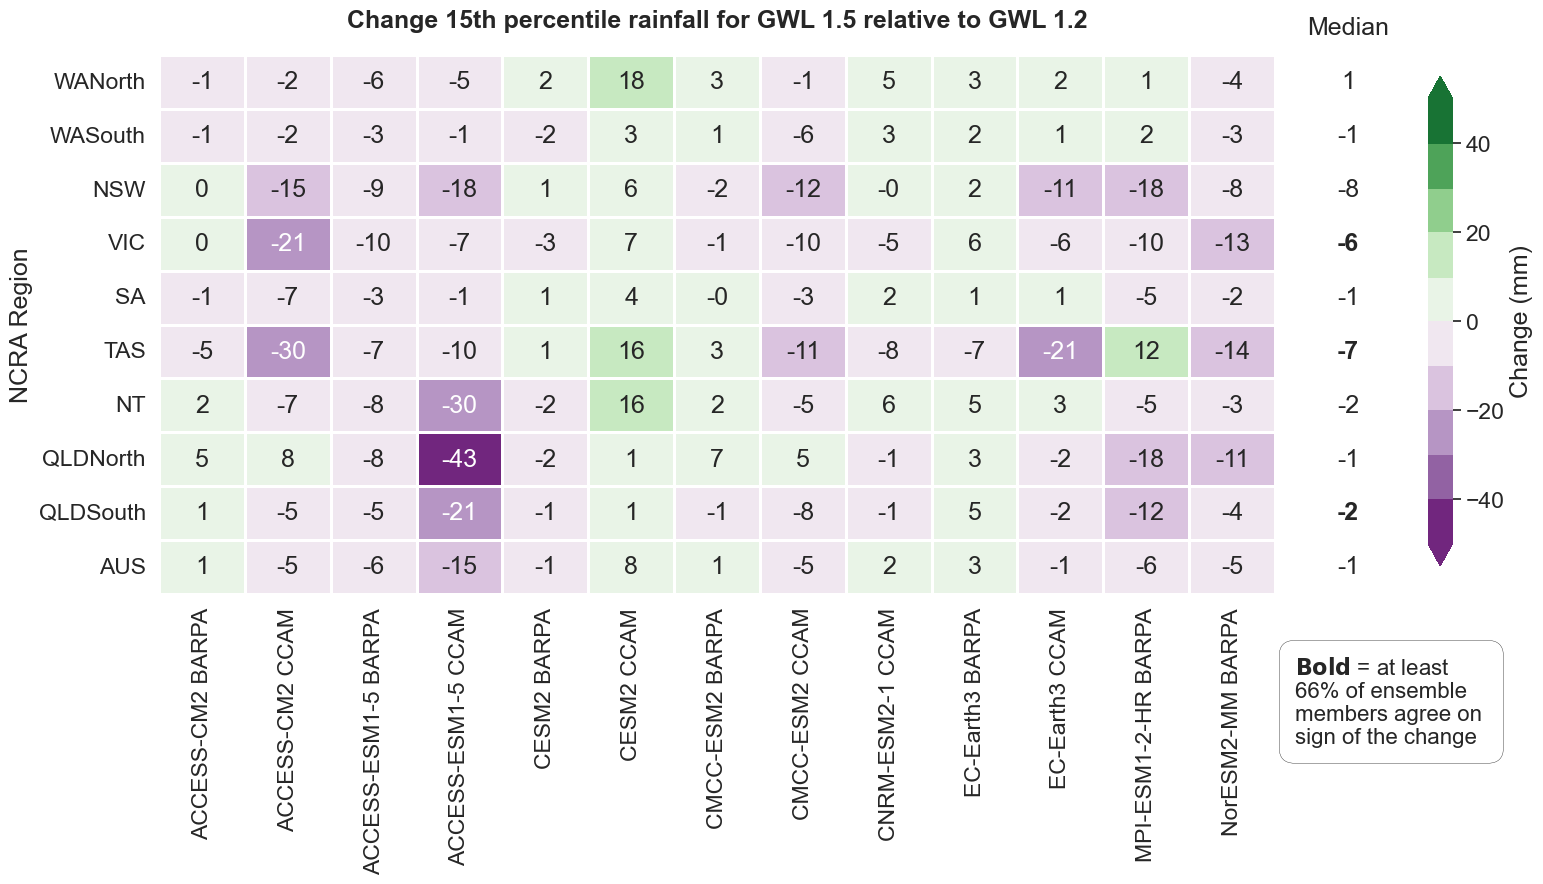

---> Plotting GWL2.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

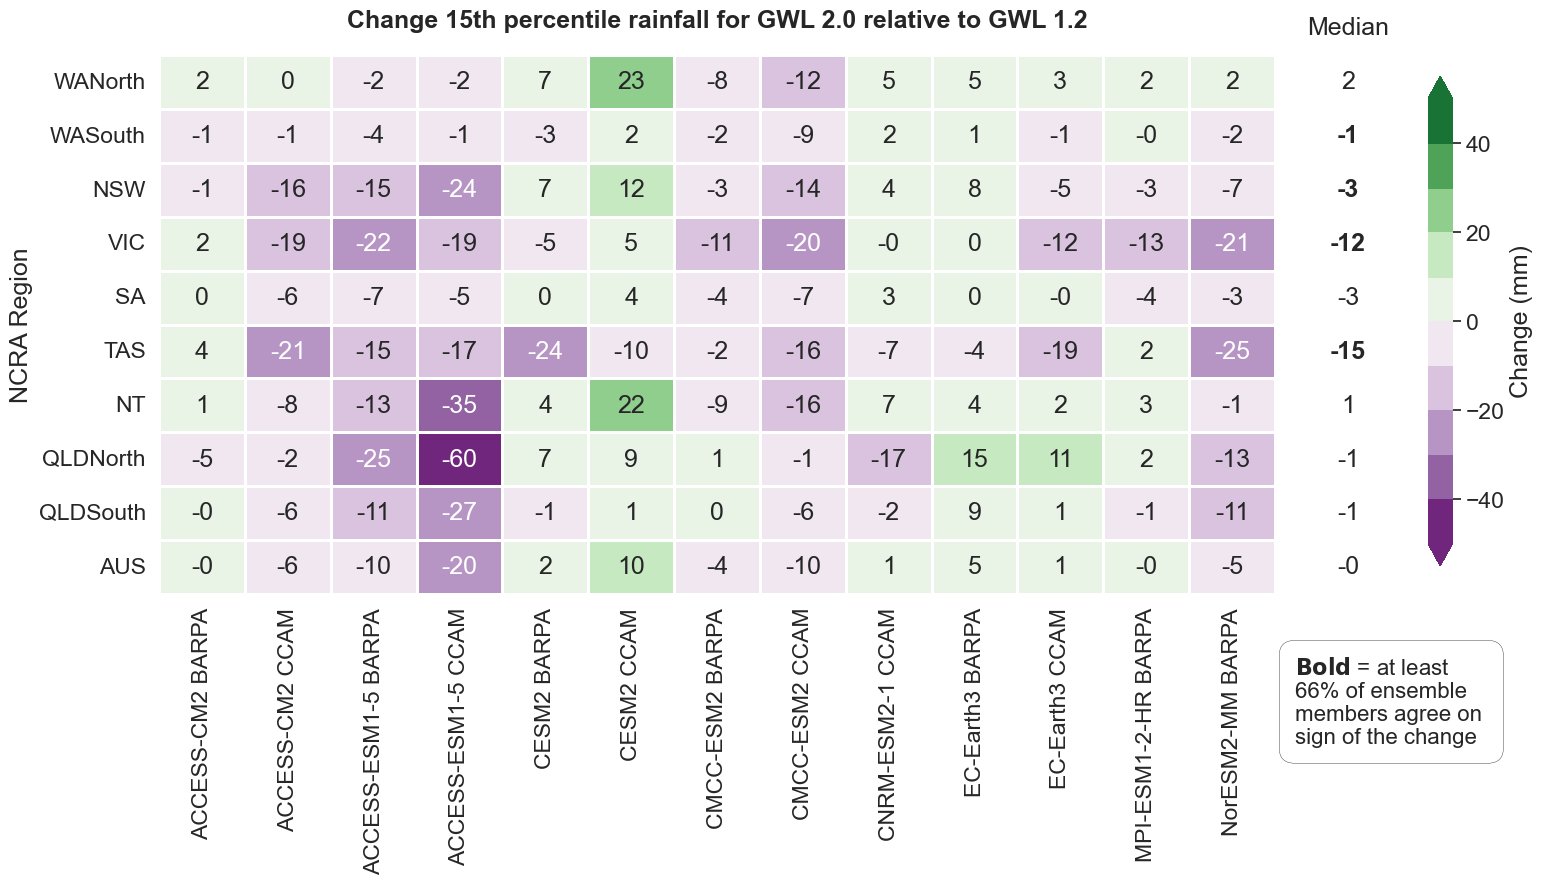

---> Plotting GWL3.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

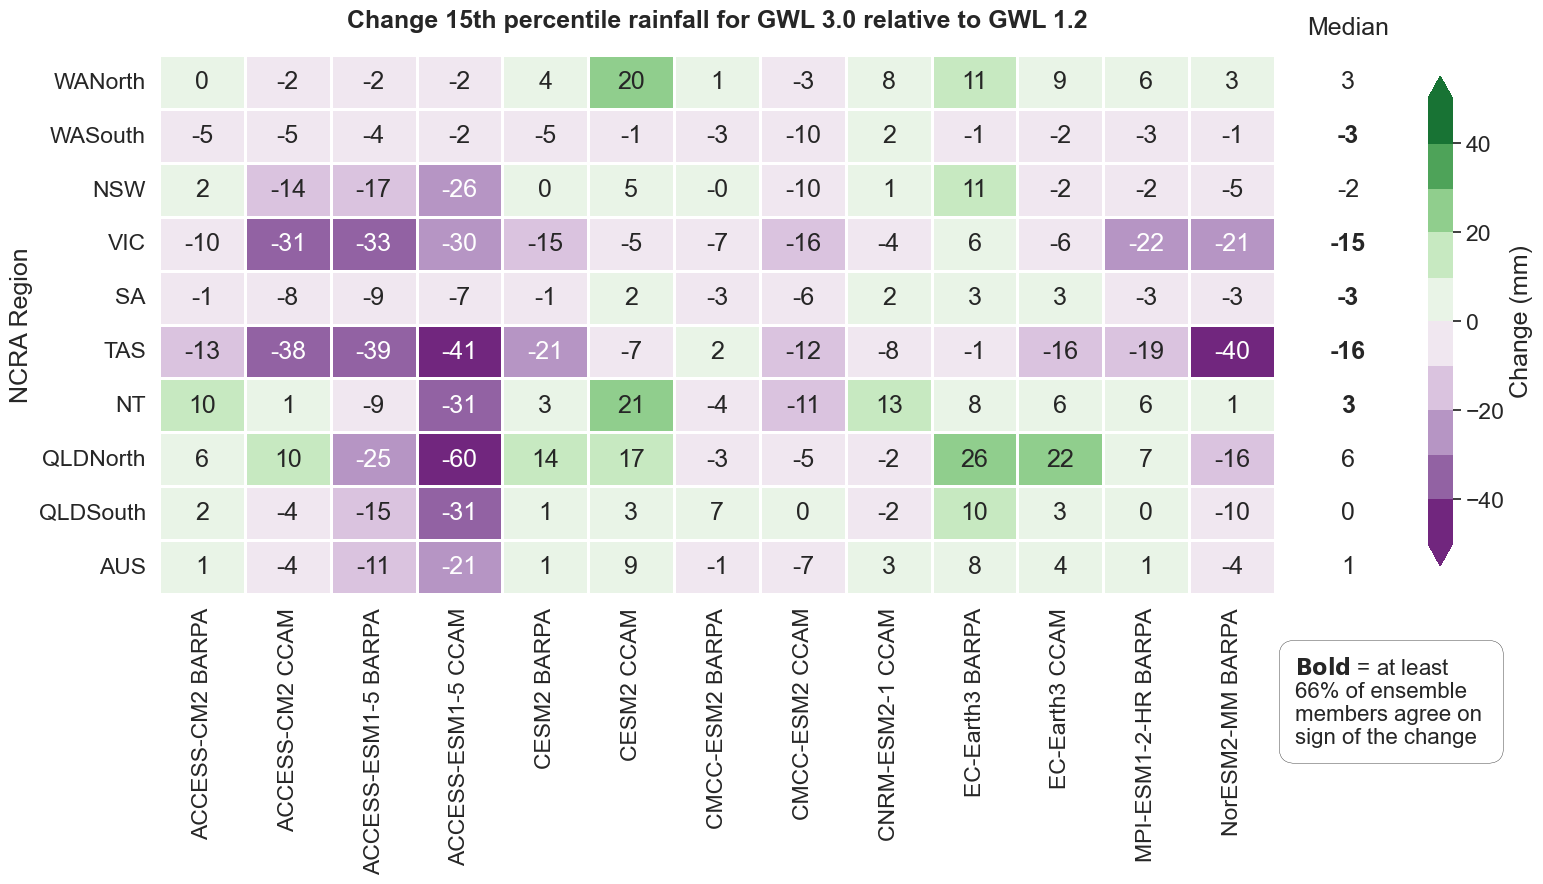

CPU times: user 12min 13s, sys: 1min 7s, total: 13min 20s
Wall time: 13min 18s


<Figure size 640x480 with 0 Axes>

In [9]:
%%time
min_max_extent = {1.5:10, 2.0:15, 3.0:20}

for GWL_level in [1.5, 2.0, 3.0]:
    df_list = []
    for file_GWL12 in files_GWL12:
        file_GWLx = [file for file in files if file_GWL12.split('_')[-7] in file and file_GWL12.split('_')[-7] in file and f'GWL{str(GWL_level)}' in file][0]
    
        ensemble_member_name = file_GWL12.split('_')[-7]+'_'+file_GWL12.split('_')[-4]
        ds_GWLx = xr.open_dataset(file_GWLx).mean(dim='month')
        ds_GWL12 = xr.open_dataset(file_GWL12).mean(dim='month')
        # GWLx_change = ((ds_GWLx - ds_GWL12)/ds_GWL12*100).rename({'p15_3month': ensemble_member_name})      
        GWLx_change = (ds_GWLx - ds_GWL12).rename({'p15_3month': ensemble_member_name})      
        mask_frac = regions.mask_3D_frac_approx(GWLx_change)
        dims = ("lat", "lon",)
        change_df = acs_regional_stats(ds=GWLx_change,var=ensemble_member_name, mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe()
        df_list.append(change_df[change_df.columns[-1]])

    plot_df = pd.concat(df_list, axis=1).rename_axis('NCRA Region')
    plot_df = plot_df.round(decimals=0)
    
    # print(f'---> Plotting GWL{str(GWL_level)} with variable colourbar across GWLs')
    # plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=True)
    
    print(f'---> Plotting GWL{str(GWL_level)} with consistent colourbar across GWLs')
    plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False)


## Do absolute heatmaps with regional mean and multi model median

In [18]:
def plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    min_max_extent = {1.5:10, 2.0:15, 3.0:20}
    sns.set(font_scale=1.5)
    plt.figure(figsize=(18, 7))
    colors = sns.color_palette("mako_r", 12)
    cmap = ListedColormap(colors)
    ticks = np.arange(0,350,50)#tick_dict["pr_mon"]
    
    ax = sns.heatmap(plot_df, annot=True, cmap=cmap, linewidth=2, fmt='.0f',
                     cbar_kws={'extend':'max', 'label':'Threshold (mm)'},
                     # center=0,
                     vmin=-(min_max_extent[GWL_level]) if variable_colourbar_switch else 0,
                     vmax=(min_max_extent[GWL_level]) if variable_colourbar_switch else 300,
                     yticklabels=list(df['abbrevs']),
                     xticklabels=[key[:-5].replace('_', ' ').replace('BOM', 'BARPA').replace('CSIRO', 'CCAM') for key in plot_df.columns])
    
    ax.text(len(plot_df.columns) + 0.85, - 0.5, 'Median' , ha='center', va='center')
    # ax.text(len(plot_df.columns) + 0.23, 12, r"$\bf{Bold}$" + ' = at least\n70% of ensemble\nmembers agree on \nsign of the change' , size=16, ha='left', va='center', bbox=dict(boxstyle="round,pad=0.7", edgecolor="black", facecolor="none", linewidth=0.25))
    for i, row in plot_df.iterrows():
        median = row.median()
        # sign_agreement = ((row>0).sum()/len(row)) if median > 0 else ((row>0).sum()/len(row))
        # fontweight = 'bold' if sign_agreement >= 0.7 else 'normal'
        ax.text(len(plot_df.columns) + 0.85, i + 0.5, f'{median:.0f}', ha='center', va='center', fontweight='normal')
        
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.83, 0.15, 0.03, 0.7])
    
    ax.set_title(f'15th percentile rainfall for GWL {str(GWL_level)}', fontweight='bold', pad=20)
    
    plt.show()
    plt.clf()
    return

---> Plotting GWL1.2 with consistent colourbar across GWLs


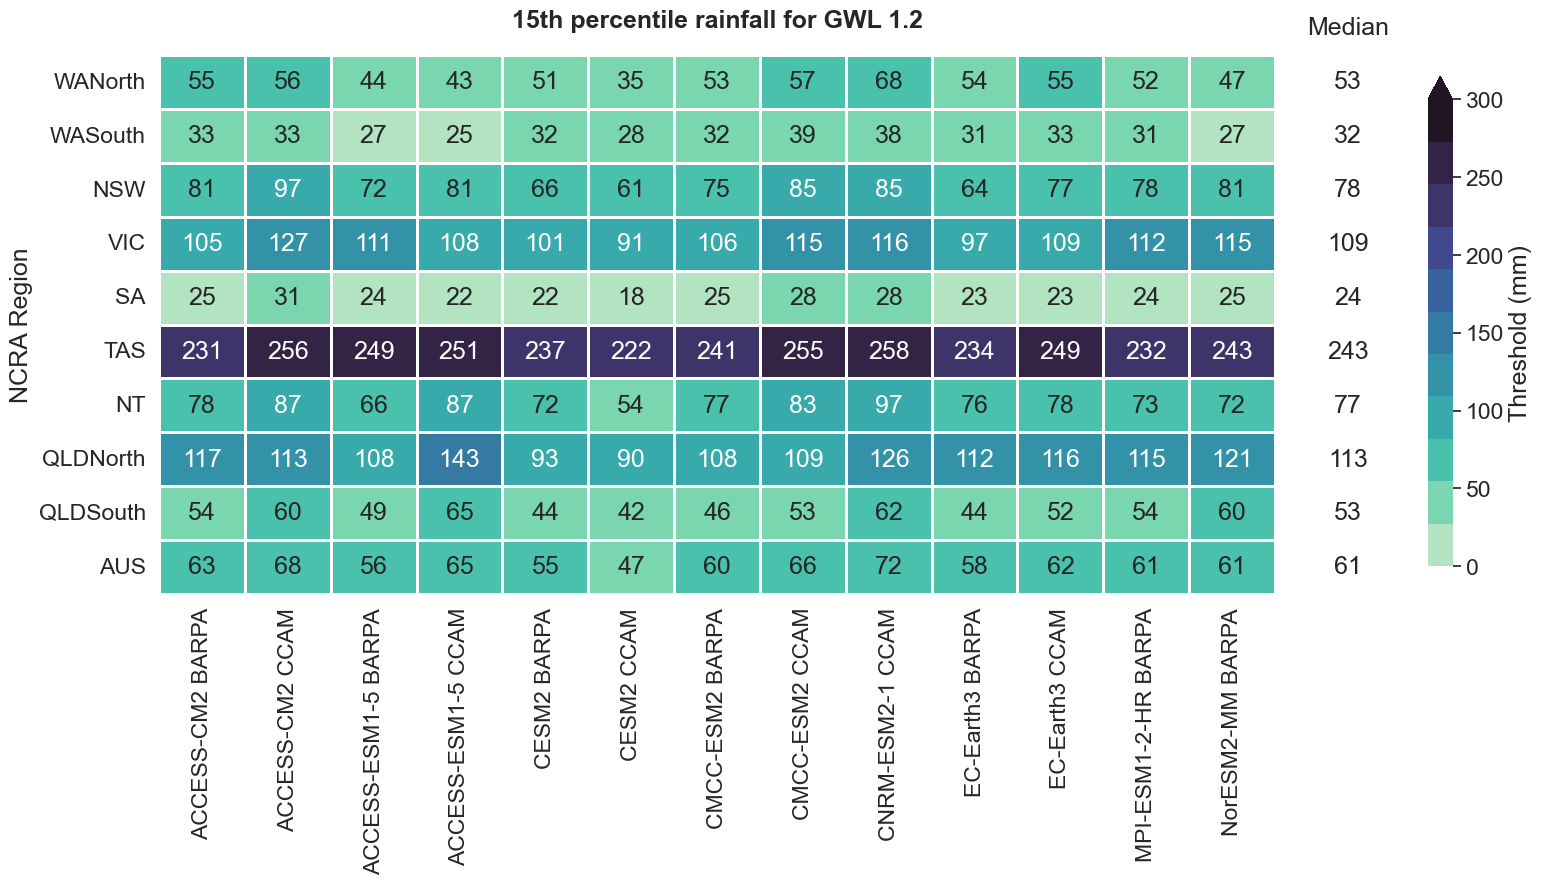

---> Plotting GWL1.5 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

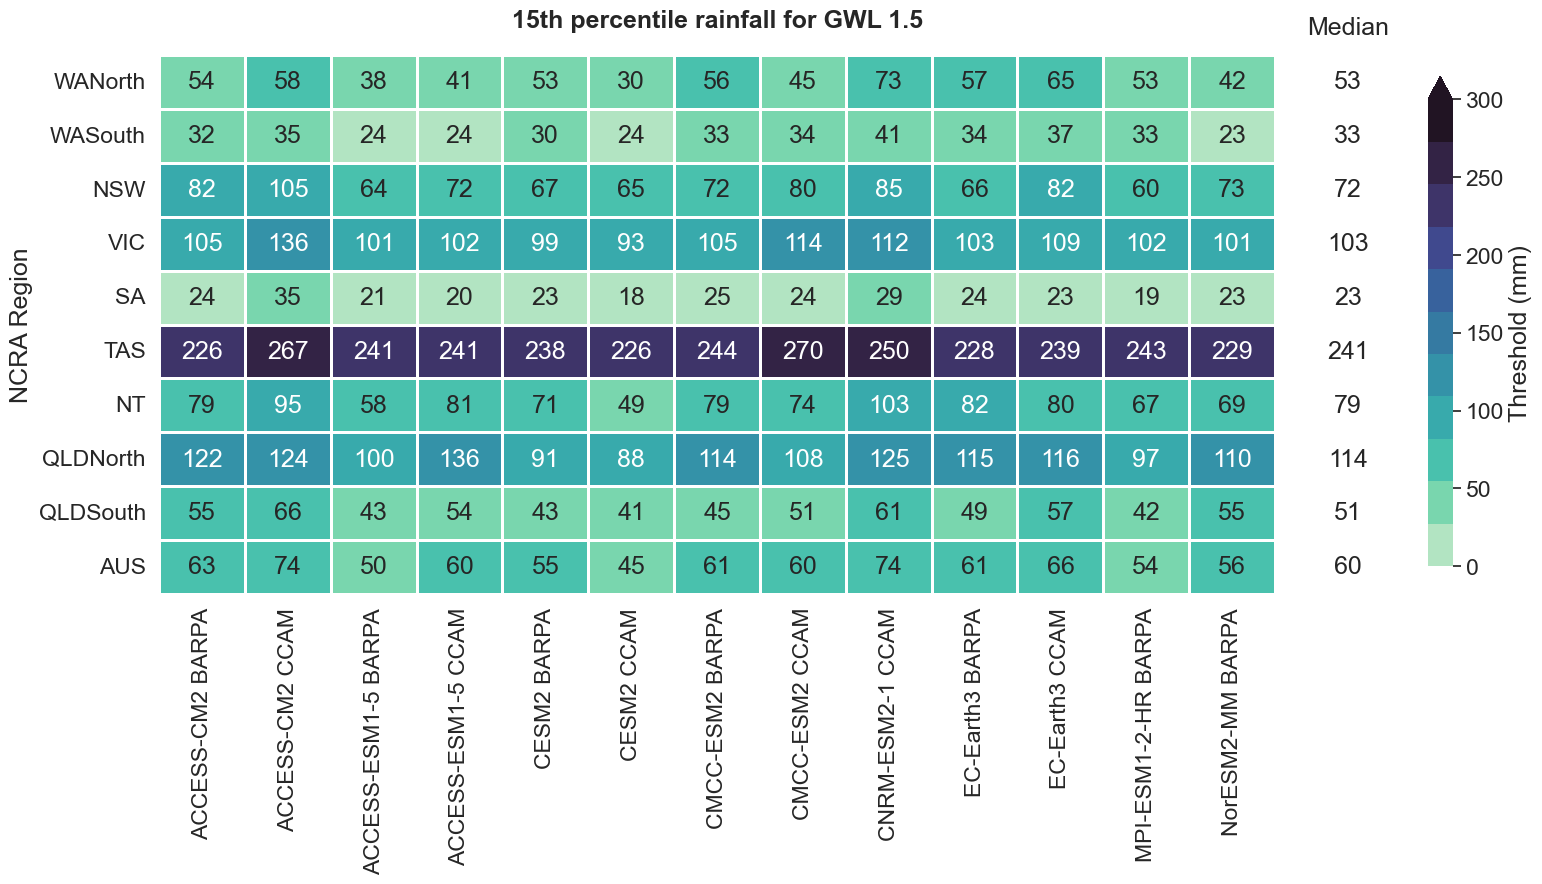

---> Plotting GWL2.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

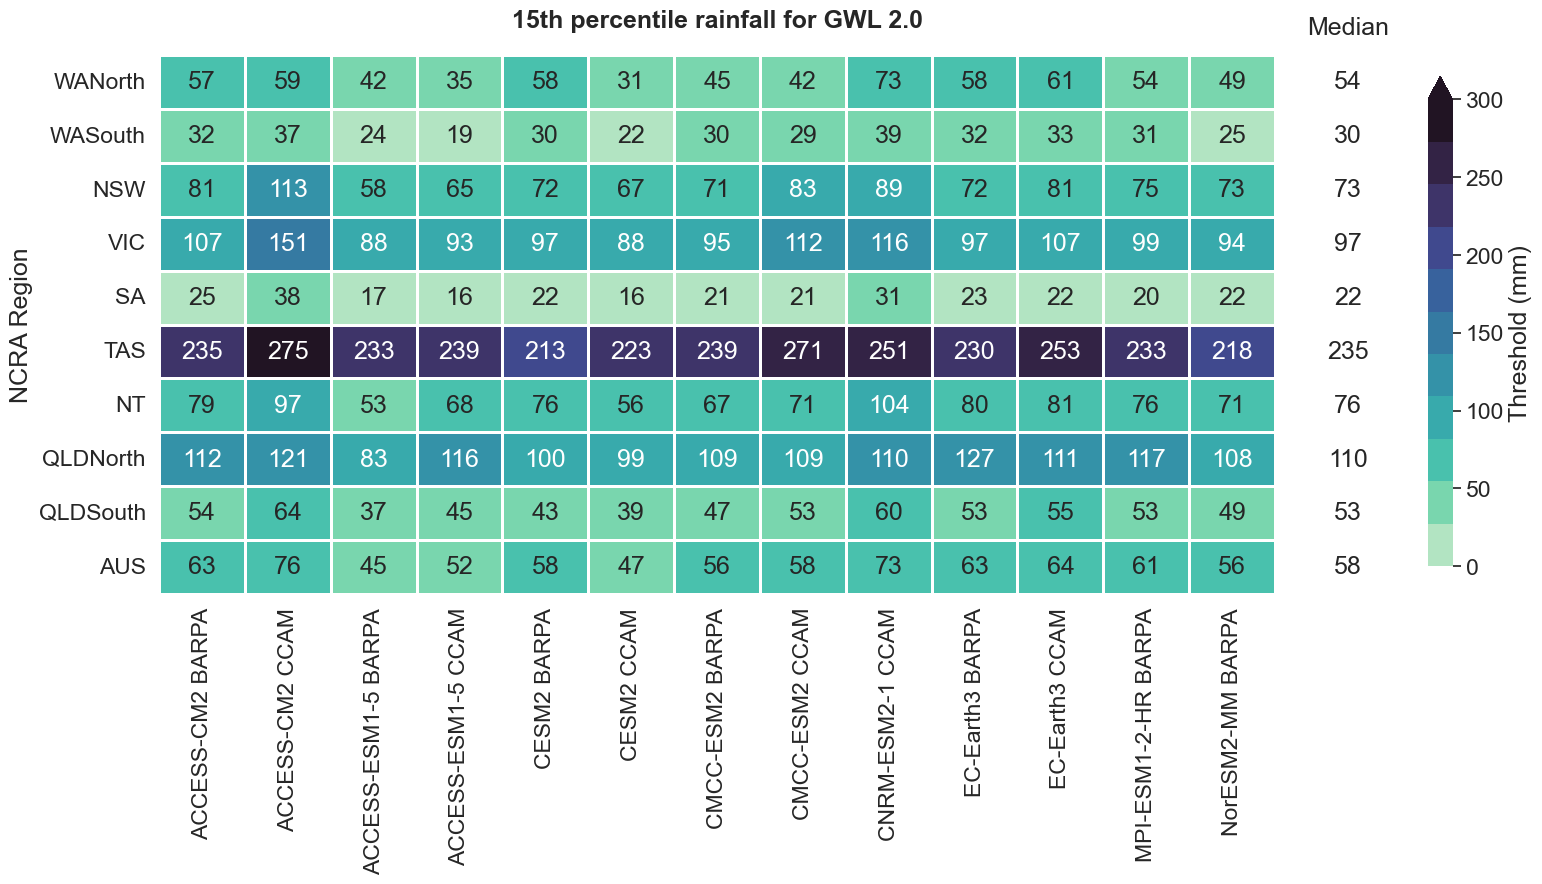

---> Plotting GWL3.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

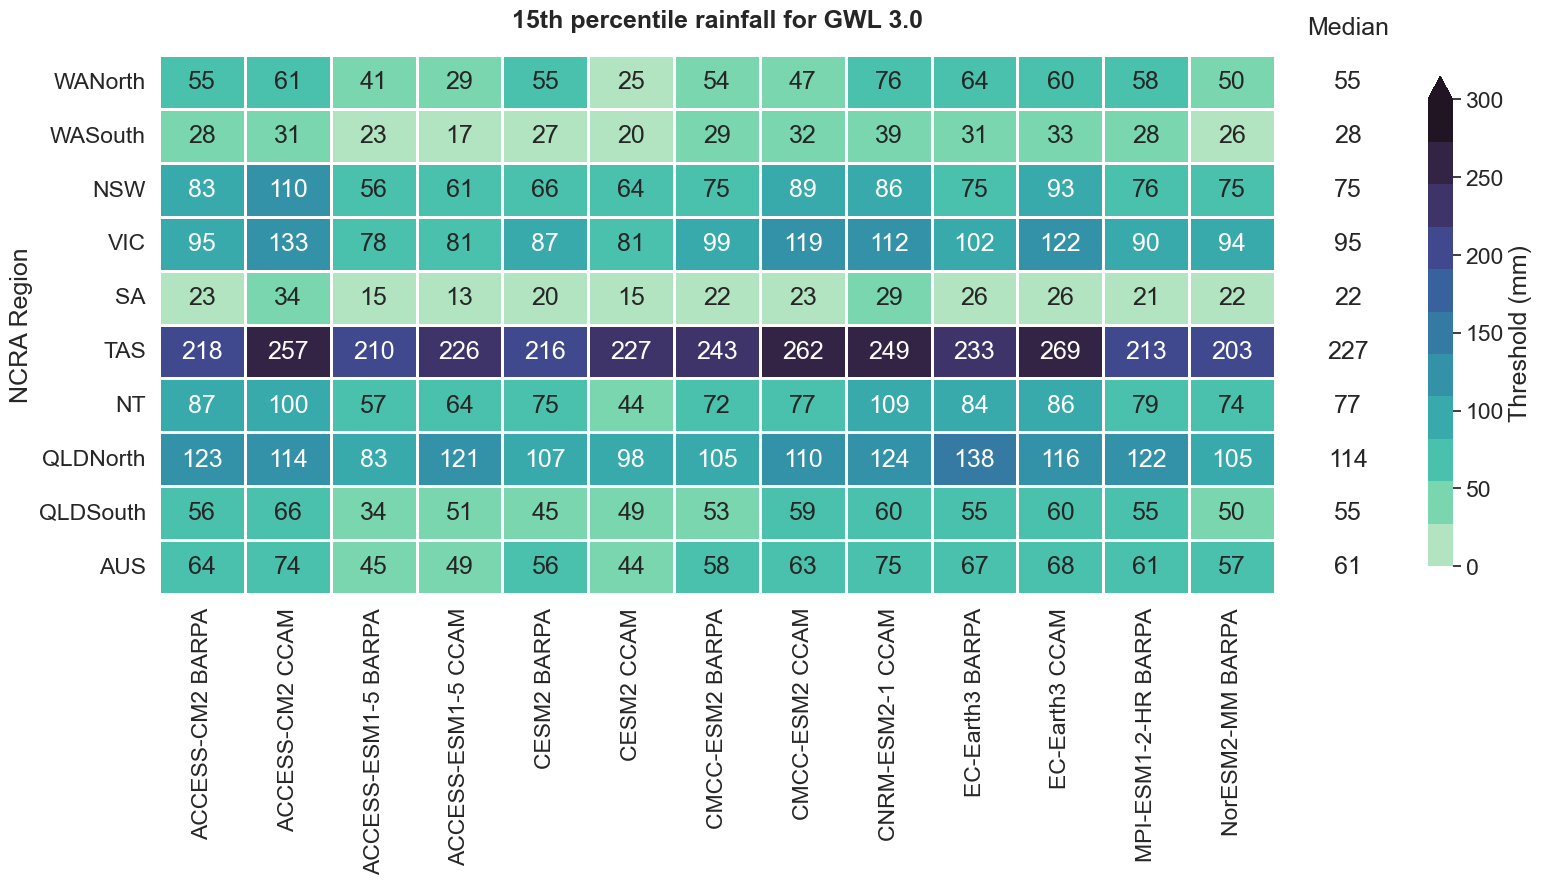

CPU times: user 16min 34s, sys: 1min 45s, total: 18min 19s
Wall time: 18min 22s


<Figure size 640x480 with 0 Axes>

In [19]:
%%time
min_max_extent = {1.5:10, 2.0:15, 3.0:20}

for GWL_level in [1.2, 1.5, 2.0, 3.0]:
    df_list = []
    for file_ in files_GWL12:
        file_GWLx = [file for file in files if file_.split('_')[-7] in file and file_.split('_')[-4] in file and f'GWL{str(GWL_level)}' in file][0]

        ensemble_member_name = file_.split('_')[-7]+'_'+file_.split('_')[-4]
        GWLx = xr.open_dataset(file_GWLx).mean(dim='month').rename({'p15_3month': ensemble_member_name})     
        mask_frac = regions.mask_3D_frac_approx(GWLx)
        dims = ("lat", "lon",)
        df = acs_regional_stats(ds=GWLx,var=ensemble_member_name, mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe()
        df_list.append(df[df.columns[-1]])

    plot_df = pd.concat(df_list, axis=1).rename_axis('NCRA Region')
    plot_df = plot_df.round(decimals=0)
    
    # print(f'---> Plotting GWL{str(GWL_level)} with variable colourbar across GWLs')
    # plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=True)
    
    print(f'---> Plotting GWL{str(GWL_level)} with consistent colourbar across GWLs')
    plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False)
